In [30]:
!pip install pmdarima

In [31]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_predict, plot_pacf
from pmdarima import auto_arima
import pandas as pd
import matplotlib
import numpy as np
from sklearn.metrics import mean_squared_error
import warnings



In [32]:
data_picker = 6100

data = pd.read_csv('NVDA.csv')
data.set_index('Date', inplace=True)
data_filtered = data['Close']
data_filtered = data_filtered.iloc[data_picker:]
print(data_filtered)

Date
2023-04-20    271.040009
2023-04-21    271.190002
2023-04-24    270.420013
2023-04-25    262.410004
2023-04-26    269.559998
                 ...    
2023-10-17    439.380005
2023-10-18    421.959991
2023-10-19    421.010010
2023-10-20    413.869995
2023-10-23    429.750000
Name: Close, Length: 129, dtype: float64


In [33]:
adf_test = adfuller(data_filtered)
print(adf_test[1])

first_differencing = data_filtered.diff().dropna()
adf_test_first_diff = adfuller(first_differencing)
print(adf_test_first_diff[1]) #data is stationary
d = 1

0.23385372928108733
3.5312626965637893e-20


## d-value

I performed the Augmented Dicky Fuller test on the raw dataset and the first-order difference of the dataset. Taking p = 0.05 as the significance level, we can conclude that the original dataset is not stationary while the first-order difference is sufficiently stationary. 

Therefore, I set d=1

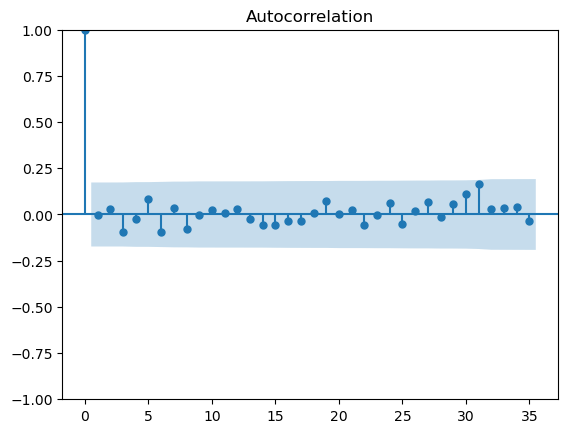

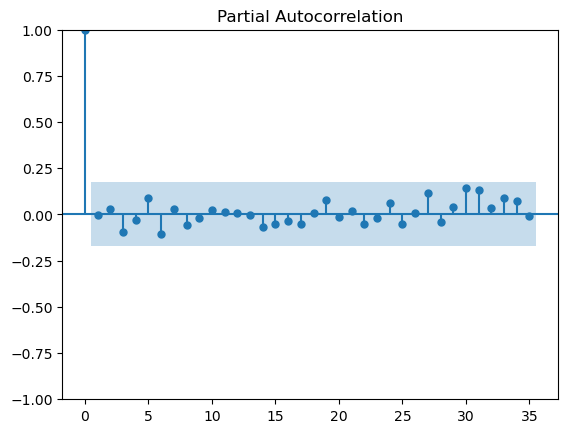

In [34]:
plot_acf(first_differencing, lags=35)
plot_pacf(first_differencing, lags=35)
plt.show()

## p and q value - ACF and PACF test

There are no spikes above the significance level in either the ACF or the PACF plots. Hence, my first thought it to set p, q = 0.

In [35]:
warnings.filterwarnings("ignore")
auto_check_arima = auto_arima(data_filtered.values, trace=True, max_q=11)
auto_check_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1004.991, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1006.991, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1006.991, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1004.334, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1008.928, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.137 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  129
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -501.167
Date:                Tue, 24 Oct 2023   AIC                           1004.334
Time:                        23:34:47   BIC                           1007.186
Sample:                             0   HQIC                          1005.493
                                - 129                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       147.3694      7.542     19.539      0.000     132.587     162.152
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               540.27
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             1.78
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## p and q value - auto_arima test

The automated method also returns the ideal order as (0,1,0), supporting my earlier assessments. With two corroborating pieces of evidence, I am willing to build an ARIMA model with (0,1,0) as the order

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  104
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -407.153
Date:                Tue, 24 Oct 2023   AIC                            816.305
Time:                        23:34:55   BIC                            818.940
Sample:                             0   HQIC                           817.372
                                - 104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       158.8710      8.816     18.021      0.000     141.592     176.150
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               492.83
Prob(Q):                              0.87   Pr

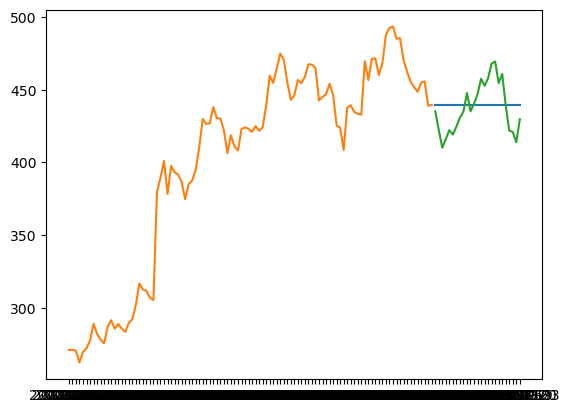

In [36]:
split_data = int(np.ceil(0.8*len(data_filtered)))
train_data = data_filtered[:split_data]
test_data = data_filtered[split_data:]

#Testing model fit to test dataset with order (0,1,0)
auto_model = ARIMA(train_data, order=(0,1,0))
auto_results = auto_model.fit()
print(auto_results.summary())
auto_test_predict = auto_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
plt.plot(auto_test_predict)
plt.plot(train_data)
plt.plot(test_data)
plt.show()

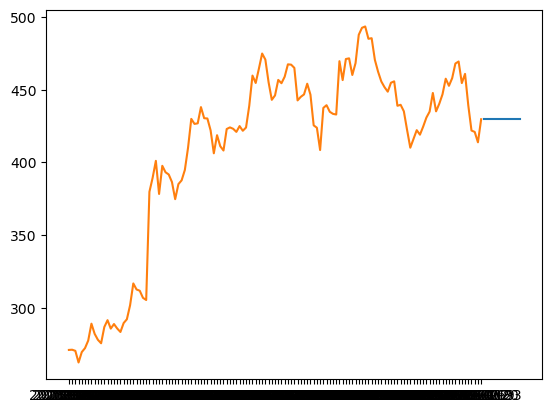

129    429.441985
130    430.770706
131    430.259754
132    430.456237
133    430.380681
134    430.409736
135    430.398563
136    430.402859
137    430.401207
138    430.401842
139    430.401598
Name: predicted_mean, dtype: float64


In [38]:
#Predicting with order (0,1,0)
auto_predictor = ARIMA(data_filtered, order=(0,1,0))
auto_training = auto_predictor.fit()
auto_predictions = auto_training.predict(start=len(data_filtered), end=len(data_filtered)+11)
plt.plot(auto_predictions)
plt.plot(data_filtered)
plt.show()

print(predictions)

## Evaluating initial model

The model seems overly simplistic as it can't seem to predict any future changes in price. It returns a straight line prediction which lacks any trend. My assessment of this is that the p and q values should not be zero. Some forums online suggested that the value of q approximates the number of days in the future the model can predict until before settling into a straight line. 

I designed my own automated test to find a more suitable value of p and q.

In [39]:
lowest_mse = None
ideal_param = {'p': 0, 'q':0}

for p in range(0,5):
    for q in range(0,12):
        model = ARIMA(train_data.values, order=(p,d,q))
        history = model.fit()

        start = len(train_data)
        end = len(train_data) + len(test_data) - 1

        pred = history.predict(start=start, end=end)
#         plt.plot(pred)
#         plt.plot(train_data)
#         plt.plot(test_data)
#         plt.title(f"p:{p}, d:{d}, q:{q}")
#         plt.show()
        mse = mean_squared_error(np.array(test_data.values), pred)
        # print(f"p: {p}\nq:{q}\nmse:{mse}")

        if lowest_mse is None:
            lowest_mse = mse
            ideal_param['p'] = p
            ideal_param['q'] = q
        else:
            if mse < lowest_mse:
                lowest_mse = mse
                ideal_param['p'] = p
                ideal_param['q'] = q


print(ideal_param)

{'p': 1, 'q': 2}


## Evaluating test

This test is not perfect. The major problem I have noticed is that the different orders produce only slightly different predictions (compared to variation in test data) and therefore the recommended order from this test will be highly dependant on how the data is sliced.

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  104
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -406.891
Date:                Tue, 24 Oct 2023   AIC                            821.783
Time:                        23:35:30   BIC                            832.322
Sample:                             0   HQIC                           826.051
                                - 104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4196      0.994     -0.422      0.673      -2.368       1.529
ma.L1          0.4350      1.002      0.434      0.664      -1.529       2.399
ma.L2          0.0850      0.161      0.527      0.5

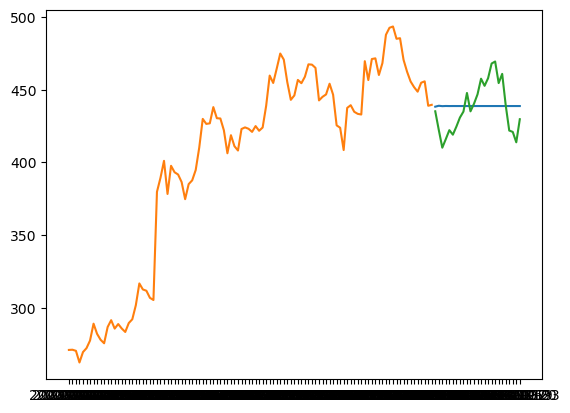

In [40]:
#Testing model fit to test dataset with order (1,1,2)
model1 = ARIMA(train_data, order=(ideal_param['p'],d,ideal_param['q']))
results1 = model1.fit()
print(results1.summary())
future1 = results1.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
plt.plot(future1)
plt.plot(train_data)
plt.plot(test_data)
plt.show()

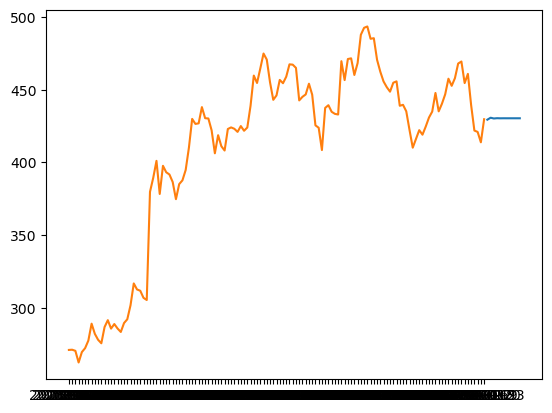

129    429.441985
130    430.770706
131    430.259754
132    430.456237
133    430.380681
134    430.409736
135    430.398563
136    430.402859
137    430.401207
138    430.401842
139    430.401598
Name: predicted_mean, dtype: float64


In [41]:
#Predicting with order (1,1,2)
model1_predictor = ARIMA(data_filtered, order=(ideal_param['p'],d,ideal_param['q']))
model1_training = model1_predictor.fit()
model1_predictions = model1_training.predict(start=len(data_filtered), end=len(data_filtered)+10)
plt.plot(model1_predictions)
plt.plot(data_filtered)
plt.show()

print(model1_predictions)

## Evalutaing Model 1

I think this model performed better than the initial model but still doesn't reflect the violatility present in the actual markets

## Another attempt 

I noticed that there was a significant spike in the autocorrelation graph at lag=31. I chose not to select q=31 initially as this spike was not above the significant value but given my reservations about the previous models, I decided to try it out.

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  104
Model:                ARIMA(1, 1, 31)   Log Likelihood                -391.028
Date:                Tue, 24 Oct 2023   AIC                            848.057
Time:                        23:35:56   BIC                            935.003
Sample:                             0   HQIC                           883.273
                                - 104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1657      0.391      0.424      0.672      -0.601       0.933
ma.L1         -0.2011      3.828     -0.053      0.958      -7.704       7.301
ma.L2          0.1186      4.740      0.025      0.9

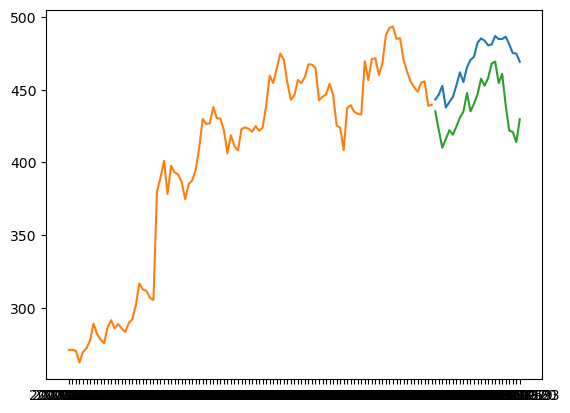

In [42]:
#Testing model fit to test dataset with order (1,1,31)
model2 = ARIMA(train_data, order=(ideal_param['p'],d,31))
results2 = model2.fit()
print(results2.summary())
future2 = results2.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
plt.plot(future2)
plt.plot(train_data)
plt.plot(test_data)
plt.show()

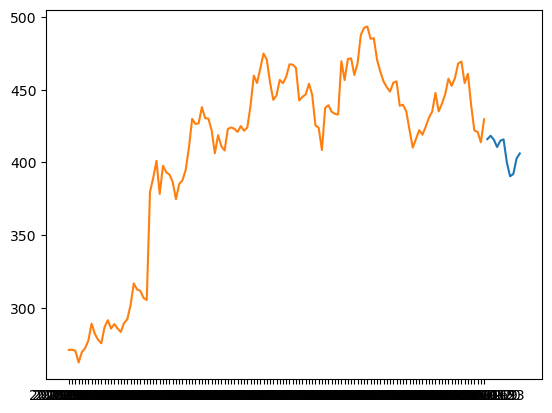

129    416.038464
130    418.366117
131    415.667022
132    410.613783
133    414.972749
134    415.883979
135    400.040030
136    390.531403
137    392.039155
138    402.691555
139    406.207520
Name: predicted_mean, dtype: float64


In [43]:
#Predicting with order (1,1,31)
model2_predictor = ARIMA(data_filtered, order=(ideal_param['p'],d,31))
model2_training = model2_predictor.fit()
model2_predictions = model2_training.predict(start=len(data_filtered), end=len(data_filtered)+10)
plt.plot(model2_predictions)
plt.plot(data_filtered)
plt.show()

print(model2_predictions)

## Final Thoughts

If I were shown three graphs of the stock market, I would certainly believe the graph produced by the (1,1,31) model was the most realistic. However, that is too subjective of a criteria for selecting a model. 

Ultimately, I will be going with order (1,1,2). Although not chosen through traditional means, it is more systematic than (1,1,31) (which is also an unusual order based on what I have seen online) and has more nuance for this dataset than (0,1,0).

I think the model lacks the ability to make meaningful predictions and requires a lot of manual tuning as the model type can change drastically based on the data and how it is split into train/test. Lastly, it is certainly not made for any long-term predictions.